<a href="https://colab.research.google.com/github/ma55530/SemEval2026-CLARITY-FER/blob/main/hierarchical/Various_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# improved_pipeline.py
# zahtijeva: transformers, datasets, sklearn, torch, accelerate

import os
import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from sklearn.metrics import precision_recall_fscore_support, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------- Config ----------
BINARY_MODEL_NAME = "microsoft/deberta-v3-base"
FINE_MODELS = [
    "microsoft/deberta-v3-base",
    "roberta-base",
    "bert-base-uncased"
]
OUTPUT_DIR = "./improved_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ----------------------------

# ---------- Utility ----------
def compute_prf_macro(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return {"precision": p, "recall": r, "f1": f}

def compute_prf_binary(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"precision": p, "recall": r, "f1": f}

def print_report(y_true, y_pred, target_names=None):
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)
    plt.show()
# ----------------------------

# ---------- Load dataset & map labels ----------
print("Loading dataset...")
ds = load_dataset("ailsntua/QEvasion")

# map clarity labels to numeric
mapping = {"Clear Reply": 0, "Ambivalent": 1, "Clear Non-Reply": 2}
def map_labels(example):
    example["label"] = mapping[example["clarity_label"]]
    example["binary_label"] = 1 if example["clarity_label"] == "Clear Non-Reply" else 0
    return example

ds = ds.map(map_labels)
# ----------------------------

# ---------- Tokenizers (SEP tokenization) ----------
print("Loading tokenizers...")
bin_tokenizer = AutoTokenizer.from_pretrained(BINARY_MODEL_NAME, use_fast=True)

fine_tokenizers = {m: AutoTokenizer.from_pretrained(m, use_fast=True) for m in FINE_MODELS}

def make_input(text_question, text_answer):
    # explicit SEP usage: many HF tokenizers auto-handle sep via pair input
    return (text_question, text_answer)

def tokenize_for_tokenizer(tokenizer):
    def fn(ex):
        q, a = make_input(ex["interview_question"], ex["interview_answer"])
        out = tokenizer(q, a, padding="max_length", truncation=True, max_length=512)
        return {**out, "label": ex["binary_label"]}  # will override for fine models later
    return fn
# ----------------------------

# ---------- Prepare datasets ----------
# Binary dataset (0: other, 1: clear non-reply)
print("Preparing binary datasets...")
bin_train = ds["train"].map(lambda ex: bin_tokenizer(ex["interview_question"], ex["interview_answer"],
                                                    padding="max_length", truncation=True, max_length=512),
                           remove_columns=[c for c in ds["train"].column_names if c not in ["label", "binary_label", "interview_question", "interview_answer"]])
# We need labels as 'labels' column for Trainer
def attach_binary_label(ex):
    return {"labels": ex["binary_label"]}
bin_train = ds["train"].map(lambda ex: {**bin_tokenizer(ex["interview_question"], ex["interview_answer"],
                                                        padding="max_length", truncation=True, max_length=512),
                                       "labels": ex["binary_label"]},
                           remove_columns=[c for c in ds["train"].column_names])
bin_test = ds["test"].map(lambda ex: {**bin_tokenizer(ex["interview_question"], ex["interview_answer"],
                                                       padding="max_length", truncation=True, max_length=512),
                                      "labels": ex["binary_label"]},
                          remove_columns=[c for c in ds["test"].column_names])

bin_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
bin_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Fine-grained datasets: only keep samples where binary_label == 0 (i.e., not Non-Reply)
print("Preparing fine-grained datasets (0 vs 1)...")
def filter_not_nonreply(ex):
    return ex["binary_label"] == 0

fine_train_ds = ds["train"].filter(filter_not_nonreply)
fine_test_ds = ds["test"].filter(filter_not_nonreply)

# For each model we need tokenized dataset with labels 0 or 1 (original label 0 or 1)
def tokenize_fine_for_model(tokenizer):
    def fn(ex):
        # original label in ds is 0 (Clear Reply) or 1 (Ambivalent) after filter
        q, a = make_input(ex["interview_question"], ex["interview_answer"])
        out = tokenizer(q, a, padding="max_length", truncation=True, max_length=512)
        out["labels"] = ex["label"]  # 0 or 1
        return out
    return fn

fine_tokenized = {}
for m, tok in fine_tokenizers.items():
    train_t = fine_train_ds.map(tokenize_fine_for_model(tok), remove_columns=fine_train_ds.column_names)
    test_t = fine_test_ds.map(tokenize_fine_for_model(tok), remove_columns=fine_test_ds.column_names)
    train_t.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_t.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    fine_tokenized[m] = {"train": train_t, "test": test_t}

# ----------------------------

# ---------- Trainer helpers ----------
def get_trainer(model_name, model_obj, train_dataset, eval_dataset, output_subdir, metric="f1", num_epochs=3, lr=2e-5):
    args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, output_subdir),
        num_train_epochs=num_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=lr,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model=metric,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        report_to="none",
        logging_strategy="epoch"
    )

    def compute_metrics_for_trainer(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        if model_obj.config.num_labels == 2:
            return compute_prf_macro(labels, preds)  # for fine we prefer macro; for binary we'll call binary func
        else:
            return compute_prf_macro(labels, preds)

    trainer = Trainer(
        model=model_obj,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics_for_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )
    return trainer
# ----------------------------

# ---------- Train binary model (DeBERTa) ----------
print("Training binary model (DeBERTa)...")
bin_model = AutoModelForSequenceClassification.from_pretrained(BINARY_MODEL_NAME, num_labels=2).to(DEVICE)
trainer_bin = get_trainer(BINARY_MODEL_NAME, bin_model, bin_train, bin_test, output_subdir="binary_deberta", num_epochs=4, lr=1e-5)

trainer_bin.train()
trainer_bin.save_model(os.path.join(OUTPUT_DIR, "binary_deberta_best"))

# ---------- Train fine-grained ensemble ----------
print("Training fine-grained ensemble...")
fine_models = {}
for m in FINE_MODELS:
    print(f"Training {m} ...")
    model = AutoModelForSequenceClassification.from_pretrained(m, num_labels=2).to(DEVICE)
    trainer = get_trainer(m, model, fine_tokenized[m]["train"], fine_tokenized[m]["test"],
                          output_subdir=f"fine_{m.replace('/', '_')}", num_epochs=3, lr=1e-5)
    trainer.train()
    trainer.save_model(os.path.join(OUTPUT_DIR, f"fine_{m.replace('/', '_')}_best"))
    fine_models[m] = AutoModelForSequenceClassification.from_pretrained(os.path.join(OUTPUT_DIR, f"fine_{m.replace('/', '_')}_best")).to(DEVICE)



Loading dataset...


Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Loading tokenizers...
Preparing binary datasets...


Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Preparing fine-grained datasets (0 vs 1)...


Filter:   0%|          | 0/3448 [00:00<?, ? examples/s]

Filter:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/3092 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Map:   0%|          | 0/3092 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Map:   0%|          | 0/3092 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Training binary model (DeBERTa)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.336300,0.203889,0.631898,0.536461,0.547671
2,0.252300,0.259443,0.687943,0.787490,0.723022
3,0.209700,0.284269,0.687943,0.787490,0.723022


Training fine-grained ensemble...
Training microsoft/deberta-v3-base ...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.645300,0.603819,0.612191,0.503902,0.431569
2,0.633400,0.582553,0.686795,0.534595,0.498611
3,0.608500,0.569013,0.703297,0.540924,0.509624


Training roberta-base ...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.646900,0.585617,0.361404,0.500000,0.419552
2,0.597000,0.554978,0.863958,0.512658,0.445959
3,0.547500,0.522214,0.731102,0.614969,0.625213


Training bert-base-uncased ...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.638600,0.580668,0.615455,0.519510,0.474059
2,0.596000,0.560810,0.739769,0.516560,0.457089


Running two-stage inference on test set...


ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

Running two-stage inference on test set...

--- KONAČNI DVOSTUPANJSKI IZVJEŠTAJ (MACRO F1) ---
                     precision    recall  f1-score   support

    Clear Reply (0)       0.82      0.18      0.29        79
     Ambivalent (1)       0.74      0.91      0.81       206
Clear Non-Reply (2)       0.41      0.65      0.50        23

           accuracy                           0.70       308
          macro avg       0.66      0.58      0.53       308
       weighted avg       0.73      0.70      0.66       308



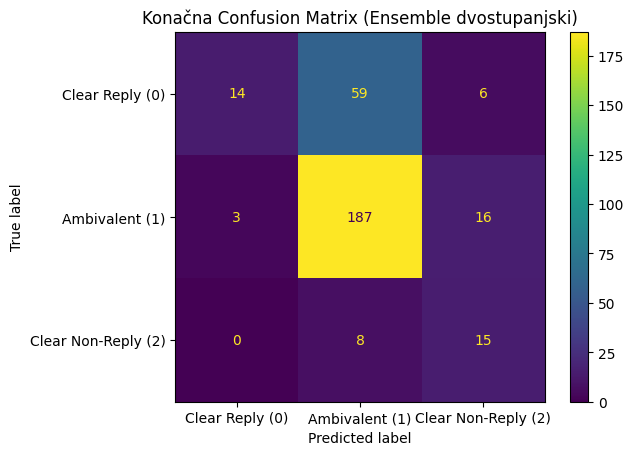

Done. Models and predictions saved to ./improved_outputs


In [ ]:
# ---------- Ensemble inference function ----------
import torch.nn.functional as F

# helper to run model & return softmax probs
def predict_probs(model, tokenizer, texts_q, texts_a, batch_size=32):
    model.eval()
    probs = []
    for i in range(0, len(texts_q), batch_size):
        qs = texts_q[i:i+batch_size]
        as_ = texts_a[i:i+batch_size]
        enc = tokenizer(qs, as_, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**enc)
            logits = out.logits
            pr = F.softmax(logits, dim=-1).cpu().numpy()
            probs.append(pr)
    return np.vstack(probs)

# two-stage classification for a list of samples
def two_stage_predict(test_df):
    qs = test_df["interview_question"].tolist()
    as_ = test_df["interview_answer"].tolist()

    # Stage 1: binary model predicts Non-Reply (1)
    bin_probs = predict_probs(bin_model, bin_tokenizer, qs, as_)
    bin_preds = bin_probs.argmax(axis=1)  # 0 or 1

    # Stage 2: for those predicted 0 (not Non-Reply), run ensemble (average probs)
    final_preds = []
    # precompute ensemble probs
    ensemble_probs = np.zeros((len(qs), 2))
    for m, model in fine_models.items():
        probs_m = predict_probs(model, fine_tokenizers[m], qs, as_)
        ensemble_probs += probs_m
    ensemble_probs /= len(fine_models)  # average
    ensemble_preds = ensemble_probs.argmax(axis=1)  # 0 or 1 (for fine)
    # map: ensemble 0 -> Clear Reply (0), ensemble 1 -> Ambivalent (1)
    for i, bpred in enumerate(bin_preds):
        if bpred == 1:
            final_preds.append(2)  # Clear Non-Reply
        else:
            final_preds.append(int(ensemble_preds[i]))  # 0 or 1
    return np.array(final_preds), bin_preds, ensemble_preds

# ---------- Run predictions on test set ----------
print("Running two-stage inference on test set...")
test_df = ds["test"].to_pandas()
y_true = test_df["label"].values
y_pred_final, bin_preds, ensemble_preds = two_stage_predict(test_df)

print("\n--- KONAČNI DVOSTUPANJSKI IZVJEŠTAJ (MACRO F1) ---")
target_names = ['Clear Reply (0)', 'Ambivalent (1)', 'Clear Non-Reply (2)']
print(classification_report(y_true, y_pred_final, target_names=target_names, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_final, display_labels=target_names)
plt.title("Konačna Confusion Matrix (Ensemble dvostupanjski)")
plt.show()

# Save predictions
np.save(os.path.join(OUTPUT_DIR, "y_pred_final.npy"), y_pred_final)
np.save(os.path.join(OUTPUT_DIR, "y_true.npy"), y_true)

print("Done. Models and predictions saved to", OUTPUT_DIR)
